## Example notebook showing use of dataset and channel model for modulation classification task.

In [4]:
#####Jupyter Stuff#####
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from ipywidgets import IntProgress,IntText,FloatProgress,FloatText
from IPython.display import display,clear_output
from tqdm import notebook

from Dataset.DigitalModulations import DigitalModulationDataset, DigitalDemodulationDataset
from Dataset.TransformsRF import *
import Dataset.models 

#####Pytorch Stuff#####
import torch
print('pytorch = ' + torch.__version__)
import torchvision
import torch.nn as nn
from reformer_pytorch import Reformer
from torch.utils.data import DataLoader

#setting GPU
torch.backends.cudnn.benchmark=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using GPU " + str(device))

#####Vanilla Python Stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#####Custom Helper Functions#####
def conf_color(matrix):
    if matrix <= 0.7:
        color = 'black'
    else:
        color = 'white'
    return color

pytorch = 1.9.0
Using GPU cuda:0


In [3]:
#quick dataset for demonstration of modulation classification task

batch_sz=512

train_channel = torchvision.transforms.Compose([Random_Fading(0.1,1.0),RandomCarrierFrequency(.01),RandomAWGN(0,30),Fix_Dtype()])
train_norm = torchvision.transforms.Compose([Normalize_Amplitude_Range(data_keys=['data','data_Tx']),Fix_Dtype(data_keys=['data','data_Tx'])])

train_dataset = DigitalModulationDataset(2**12,num_samples=512,transform=train_channel,normalize_transform=train_norm,
                                      min_samp=8,max_samp=16,need_tx=True)
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle=True,
                          num_workers=16, pin_memory=True, drop_last=False)

val_channel = train_channel
val_norm = train_norm

val_dataset = DigitalModulationDataset(2**8,num_samples=512,transform=val_channel,normalize_transform=val_norm,
                                     min_samp=8,max_samp=16,need_tx=True)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle=False,
                        num_workers=16, pin_memory=True, drop_last=False)

In [4]:
#Training classifier on data through fading channel on hybrid model

model = models.Hybrid(input_samples=512, n_classes=13,debug=False)
model.to(device)
model = nn.DataParallel(model, device_ids=[0,1])
#model.load_state_dict(torch.load('Trained_Models/classification.pt'))

conf_matrix = np.zeros((len(train_dataset.classes),len(train_dataset.classes)))
conf_matrix_2 = np.zeros((len(val_dataset.classes),len(val_dataset.classes)))
epoch_nums = 16
best_accuracy = -1000

criterion_classifier = nn.CrossEntropyLoss()
criterion_recon = nn.MSELoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=.001)

alpha = 1
beta = 1

for epoch in notebook.tqdm(range(epoch_nums),desc='Epoch'):
    model.train()
    for item in notebook.tqdm(train_loader,desc='Training',leave=False):
        RXinputs = item['data'].to(device)
        TXinputs = item['data_Tx'].to(device)
        labels = item['label'].to(device)
        optimizer.zero_grad()
        outputs,recon = model(RXinputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss_classify = alpha*criterion_classifier(outputs,labels)
        loss_recon = beta*(criterion_recon(recon,TXinputs))
        loss = loss_classify + loss_recon
        
        loss.backward()
        optimizer.step()
        
        if epoch == epoch_nums-1:
            for i in range(RXinputs.shape[0]):
                label = labels[i]
                pred = predicted[i]
                conf_matrix[label,pred]+=1
        
    correct = 0    
    model.eval()    
    for item in notebook.tqdm(val_loader,desc='Validation',leave=False):
        RXinputs = item['data'].to(device)
        TXinputs = item['data_Tx'].to(device)
        labels = item['label'].to(device)
        optimizer.zero_grad()
        outputs,recon = model(RXinputs)
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().cpu().data.numpy()
        
        if epoch == epoch_nums-1:
            for i in range(RXinputs.shape[0]):
                label = labels[i]
                pred = predicted[i]
                conf_matrix_2[label,pred]+=1
        
    accuracy = correct/float(len(val_loader)*batch_sz)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        #torch.save(model.state_dict(), "Trained_Models/classification.pt")    

    if epoch == epoch_nums-1: 
        for i in range(len(conf_matrix_2)):
            conf_matrix_2[i]=conf_matrix_2[i]/conf_matrix_2[i].sum() 
            
        for i in range(len(conf_matrix)):
            conf_matrix[i]=conf_matrix[i]/conf_matrix[i].sum() 

/home/shev492/anaconda3/envs/cheese/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


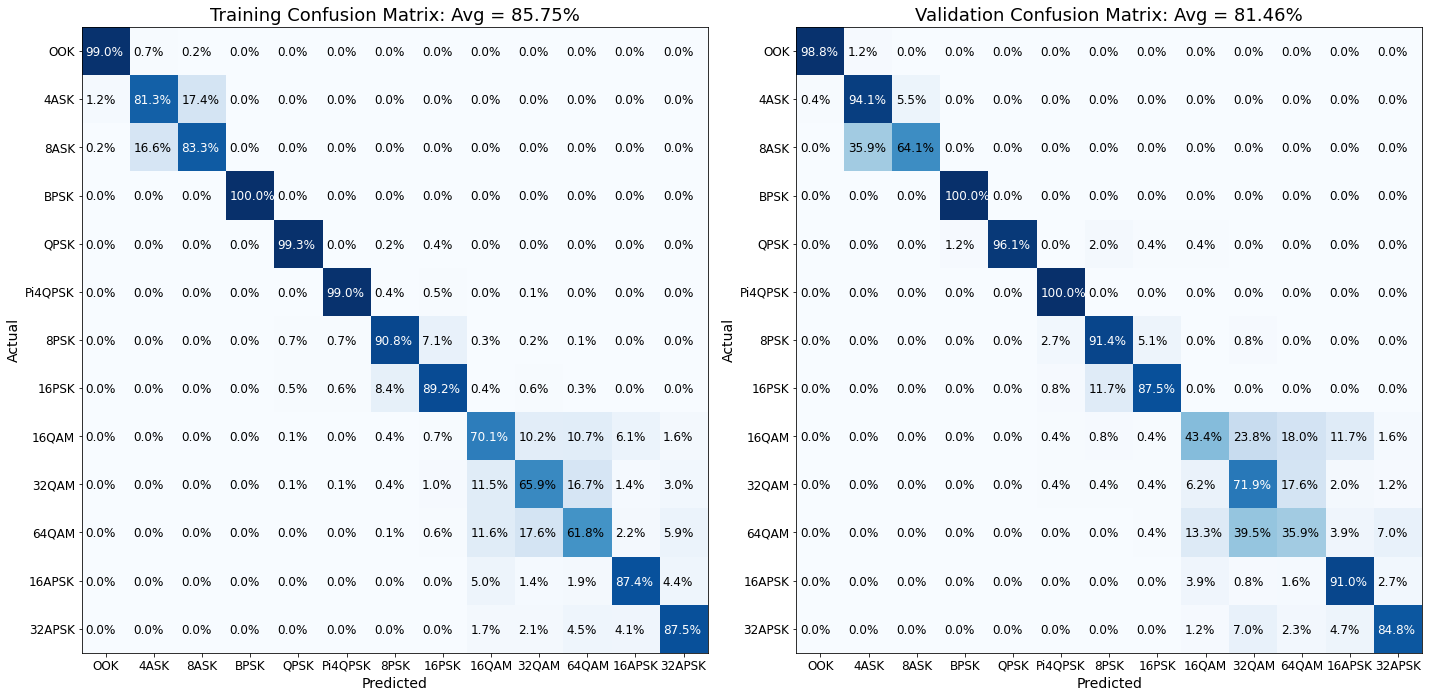

In [5]:
#confusion for train and val averaged across all snrs.

fig,ax = plt.subplots(1,2,figsize=(20,10))

cmap='Blues'
ax[0].imshow(conf_matrix,cmap=cmap)
ax[1].imshow(conf_matrix_2,cmap=cmap)
classes = val_dataset.classes
        
for i in range(len(classes)):
    for j in range(len(classes)):
        num = conf_matrix[i,j]*100
        ax[0].text(j-0.43,i+.1, '{:2.1f}'.format(num) + "%", color=conf_color(conf_matrix[i,j]), fontsize=12)
        
        num = conf_matrix_2[i,j]*100
        ax[1].text(j-0.43,i+.1, '{:2.1f}'.format(num) + "%", color=conf_color(conf_matrix_2[i,j]), fontsize=12)

for aaxx in ax:
        
    aaxx.set_xticks(np.arange(0,len(classes)))
    aaxx.set_xticklabels(classes,fontsize=12)

    aaxx.set_yticks(np.arange(0,len(classes)))
    aaxx.set_yticklabels(classes,fontsize=12)

    aaxx.set_ylabel('Actual',fontsize=14)
    aaxx.set_xlabel('Predicted',fontsize=14)

ax[0].set_title('Training Confusion Matrix: Avg = ' + '{:2.2f}'.format(100*conf_matrix.diagonal().mean()) + "%",fontsize=18)    
ax[1].set_title('Validation Confusion Matrix: Avg = ' + '{:2.2f}'.format(100*conf_matrix_2.diagonal().mean()) + "%",fontsize=18)

plt.tight_layout()
plt.show()

In [3]:
#accuracy vs snr experiment
device = 'cuda:0'
model = models.Hybrid(input_samples=512, n_classes=13,debug=False)
model.to(device)
model = nn.DataParallel(model, device_ids=[0,1])
#model.load_state_dict(torch.load('Trained_Models/classification.pt'))

batch_sz=512

snrs = np.arange(-30,31,1)[::-1]
results = []

acc_text = FloatText(value=0,description='Current Accuracy',style={'description_width': 'initial'})
display(acc_text)
prog_text = IntText(value=0,description='Current SNR',style={'description_width': 'initial'})
display(prog_text)

for sss in notebook.tqdm(snrs):

    prog_text.value = sss
    channel = torchvision.transforms.Compose([Random_Fading(0.1,1.0),RandomCarrierFrequency(.01),
                                              AWGN(sss),Fix_Dtype()])
    norm = torchvision.transforms.Compose([Normalize_Amplitude_Range(data_keys=['data','data_Tx']),
                                       Fix_Dtype(data_keys=['data','data_Tx'])])
    
    dataset = DigitalModulation_data(2**12,num_samples=512,min_samp=8,max_samp=8,
                                     transform=channel,normalize_transform=norm,need_tx=True)
    loader = DataLoader(dataset,batch_size=batch_sz, shuffle=True,
                          num_workers=16, pin_memory=True, drop_last=False)

    conf_matrix = np.zeros((len(dataset.classes),len(dataset.classes)))

    correct = 0
    model.eval()
    for item in loader:
        RXinputs = item['data'].cuda()
        TXinputs = item['data_Tx'].cuda()
        labels = item['label'].cuda()

        outputs,recon = model(RXinputs)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().cpu().data.numpy()
        for i in range(RXinputs.shape[0]):
            label = labels[i]
            pred = predicted[i]
            conf_matrix[label,pred]+=1
    accuracy = correct/float(len(loader)*batch_sz)
    acc_text.value = accuracy
    
    for i in range(len(conf_matrix)):
        conf_matrix[i]=conf_matrix[i]/conf_matrix[i].sum()
    results.append(conf_matrix)
results = np.array(results)
#np.save('classifier_SNR_accuracy.npy',results)

FloatText(value=0.0, description='Current Accuracy', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Current SNR', style=DescriptionStyle(description_width='initial'))

  0%|          | 0/81 [00:00<?, ?it/s]

0.9874549278846154


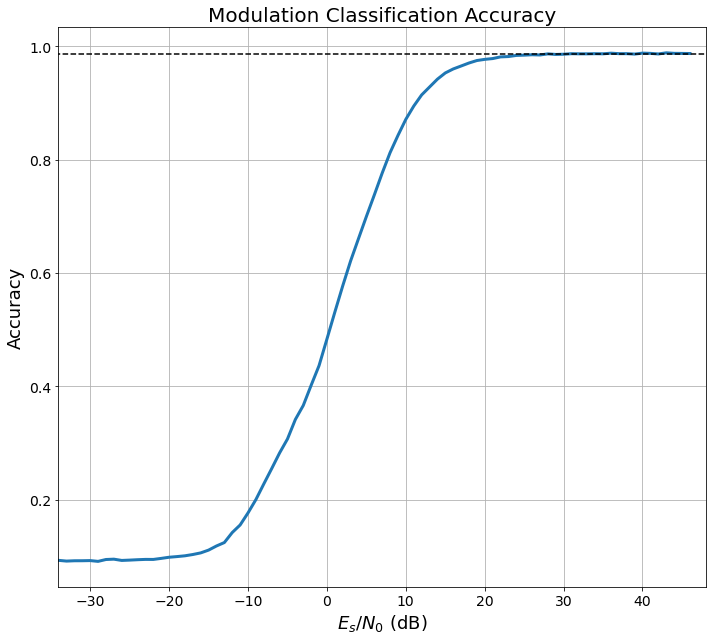

In [4]:
#results = np.load('classifier_SNR_accuracy.npy')
oversamp = 8
snrs = np.arange(-30,31,1)[::-1]

fig,ax = plt.subplots(1,1,figsize=(10,9))
acc_snr = np.array([np.diagonal(res).mean() for res in results])

meow = acc_snr[0]

ax.plot(snrs,acc_snr,linewidth=3)
ax.plot([-100,100],[meow,meow],'--k')
ax.set_xlim(-34,48)
ax.grid()

ax.set_title('Modulation Classification Accuracy',fontsize=20)
ax.set_ylabel('Accuracy',fontsize=18)
ax.set_xlabel('SNR (dB)',fontsize=18)
#ax.text(10,0.5,'ass',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

print(meow)
plt.tight_layout()
#plt.savefig('modulation_classify_SNR.pdf',dpi=300)
#plt.show()